In [47]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]


### Multi-quantile estimations

In [48]:
# Dataset generation
distros = ['mix', 'gau_1', 'gau_2', 'exp']

def get_one_dt(distro, datasize):
#     return np.ones(size)
    if distro == 'gau_1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau_2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        # mean: -1.3
        # std: 30.779035604224564
        # var: 947.3490327261234
        mix_lst = np.zeros(datasize)
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25])
        mixtures = [(2,7), (0,0.7), (36, 26), (5,77), (-77,7)]
        acc_sizes = [sum(sizes[:i+1]) for i in range(len(sizes))]

        for d_idx in range(datasize):
            rdn = np.random.uniform(0,1)
            mix_id = 0
            for m_id in acc_sizes:
                if rdn > m_id:
                    mix_id += 1
                else:break
            data_point = np.random.normal(mixtures[mix_id][0], mixtures[mix_id][1])
            mix_lst[d_idx] = data_point
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)*6.5 - 20
    else: raise Exception("distribution doesn't work!")

In [49]:
# dt = get_one_dt('exp', 10000)
# plt.hist(dt, bins=100)

#### Joint Tracking of Multiple Quantiles Through Condition Quantiles

1. Algo based on DUMIQUE (basically SGD but claim itself not ablt to deal with non-positive quantiles directly)

In [50]:
# not sure why *q_est --> Cannot deal with q_est<0
def DUMIQUE(q_est, x, tau, stepsize):
    if x > q_est:
        q_est += (stepsize*q_est)*tau
    else:
        q_est += (stepsize*q_est)*(tau-1)
    return q_est

# SGD which works for q_est non positive, only constant stepsize
def sgd(q_est, x, tau, stepsize):
    if x > q_est:
        q_est += stepsize*tau
    else:
        q_est += stepsize*(tau-1)
    return q_est

In [51]:
# print (DUMIQUE(0, 1, 0.7, 1))
# print (sgd(0, 1, 0.7, 1))
l = [0]
l.extend([1])
l

[0, 1]

In [227]:
def checkinput(q_est):
    q_new = [0]
    q_new.extend([q_est[i] for i in range(len(q_est)-1)])
    for i in range(len(q_est)):
        if q_new[i] >= q_est[i]: return False
    return True

# sX is stepsize_X, sY is stepsize_Y
# c = 2 because 0.5 is at tau_vals[2]
def shiftQ(dataset, tau_lst, sX, sY, qX, qY, c=0):
    if not (checkinput(qX) and checkinput(qY)):
        raise Exception("Input quantile estimate not applicable")
    proc = np.zeros((len(dataset), len(tau_lst)))
    for i, x in enumerate(dataset):
        qX[c] = DUMIQUE(qX[c], x, tau_lst[c], sX)
        
        for k in range(c-1, -1, -1):
            tau = tau_lst[k]
            yk =  qX[k+1] - x
            qY[k] = DUMIQUE(qY[k], yk, 1-tau, sY)
            qX[k] = qX[k+1] - qY[k]
#             print ('yk', yk)
#             print ('qY', qY)
#             print ('qX', qX)
        
        for k in range(c+1, len(qX)):
            tau = tau_lst[k]
            yk = -qX[k-1] + x
            qY[k] = DUMIQUE(qY[k], yk, tau, sY)
            qX[k] = qX[k-1] + qY[k]
#             print ('yk',yk)
#             print ('qY', qY)
#             print ('qX', qX)
#         print ('qY', qY)
        proc[i] = qX
    return proc


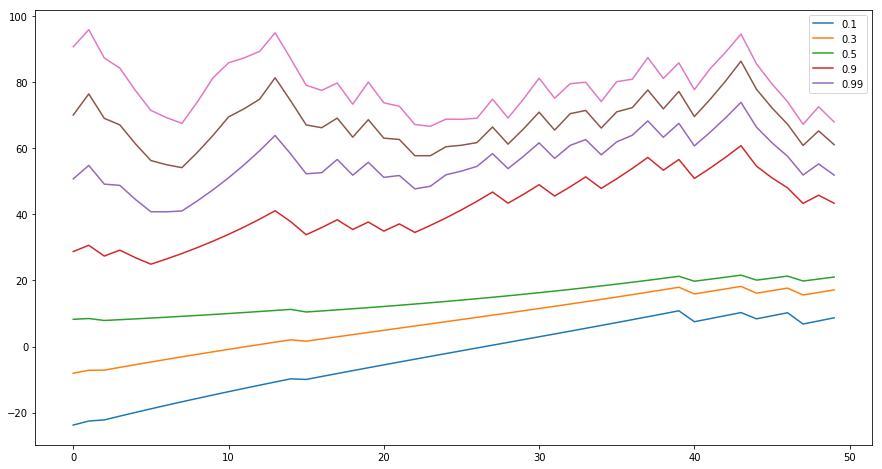

[[ 9.3081465  16.91448058 20.71024415 51.0582461  61.68349519 72.23568216
  79.48499641]
 [10.23341105 17.68761845 21.33155148 48.03779319 57.60051737 67.30852939
  74.12288478]
 [ 6.81541583 15.61138056 19.83834287 43.33983558 51.94628734 60.8776584
  67.28315247]
 [ 7.75556391 16.37560934 20.43349316 45.81510529 55.28220222 65.2853378
  72.58760104]
 [ 8.70328496 17.15092949 21.04649796 43.38231663 51.90270387 61.1055886
  67.96971605]]


In [233]:
dataset = np.random.uniform(0, 100, 50)
qX = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]) +5
qY = np.asarray(qX) + 10
proc = shiftQ(dataset, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 0.1, 0.2, qX, qY, 2)
# print (proc)
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
ax.plot(proc)
ax.legend(tau_vals)
plt.show()

print (proc[-5:, :])


In [225]:
c = 2
[k for k in range(c, len(qX))]

[2, 3, 4, 5, 6]